In [1]:
import tensorflow as tf
from glob import glob
import numpy as np
import pickle
import json
import os
import random
import matplotlib.pyplot as plt

In [2]:
# only using CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
def save_data(output_path, mydata):
    with open(output_path, 'wb') as f:
        
        pickle.dump(mydata, f)
        
def load_data(data_path):
    data = pickle.load(open(data_path, 'rb'))

    return data

def convert_binary_score(severe_score):
    
    if severe_score >= 10:
        return 1
    else:
        return 0
    
def lower_filepath(filepath):
    
    filename, fileformat = filepath.split(".")
    fileformat = fileformat.lower()
    
    converted_filepath = filename + "." + fileformat
    
    return converted_filepath
    
def shuffle_data(mydata):
    mydata = np.array(mydata)
    idx = np.arange(len(mydata))
    random.shuffle(idx)
    
    return list(mydata[idx])
    
def filter_available_visits(amd_record_visit):
    
    filtered_visits = []
    
    for visit in amd_record_visit:
        re_label_test = False
        re_data_test = False
        le_label_test = False
        le_data_test = False
        
        try:
            this_re_severe_score = visit["AMDSEVRE"]
            if np.isnan(this_re_severe_score):
                re_label_test = False
            else:
                re_label_test = True
        except:
            continue
        
        try:
            this_le_severe_score = visit["AMDSEVLE"]
            if np.isnan(this_le_severe_score):
                le_label_test = False
            else:
                le_label_test = True
        except:
            continue
            
        try:
            this_re_data = visit["RE_IMG"]
            if len(this_re_data) > 0:
                re_data_test = True
            else:
                re_data_test = False
        except:
            continue
            
        try:
            this_le_data = visit["LE_IMG"]
            if len(this_le_data) > 0:
                le_data_test = True
            else:
                le_data_test = False
        except:
            continue
            
        test_result = re_label_test * le_label_test * re_data_test * le_data_test
        
        if test_result == 1:
            filtered_visits.append(visit)
            
    return filtered_visits

In [4]:
def build_patient_dict(data_dir, remove_recurrent=True):
    
    json_data = open(data_dir)
    amd_data = json.load(json_data)
    patient_dict = dict()
    
    count_idx = 0
    count_patient = 0
    count_removed_patient = 0
    for idx, record in enumerate(amd_data):
        count_patient += 1
        if idx % 100 == 0:
            print("{} patients processed...".format(count_idx*100))
            count_idx += 1
        
        this_id = record["ID2"]
        this_visits = record["VISITS"]
        filtered_visits = filter_available_visits(this_visits)
        this_re = dict()
        this_le = dict()
        
        re_year = []
        le_year = []
        re_img = []
        le_img = []
        re_severe_score = []
        le_severe_score = []
        re_late_amd = []
        le_late_amd = []
        
        if len(filtered_visits) <= 1:
            count_removed_patient += 1
            continue
            
        for i, visit in enumerate(filtered_visits):
            
            re_year.append(int(visit["VISNO"])/2)
            le_year.append(int(visit["VISNO"])/2)
            re_img.append(lower_filepath(visit["RE_IMG"]))
            le_img.append(lower_filepath(visit["LE_IMG"]))
            re_severe_score.append(visit["AMDSEVRE"])
            le_severe_score.append(visit["AMDSEVLE"])
            re_late_amd.append(convert_binary_score(visit["AMDSEVRE"]))
            le_late_amd.append(convert_binary_score(visit["AMDSEVLE"]))
            
        re_late_amd = np.array(re_late_amd)
        le_late_amd = np.array(le_late_amd)
        
        this_re["re_year"] = re_year
        this_re["re_img"] = re_img
        this_re["re_severe_score"] = re_severe_score
        this_re["re_late_amd"] = re_late_amd
        
        this_le["le_year"] = le_year
        this_le["le_img"] = le_img
        this_le["le_severe_score"] = le_severe_score
        this_le["le_late_amd"] = le_late_amd
        
        patient_late_amd_check = np.sum(re_late_amd) + np.sum(le_late_amd)
        
        if patient_late_amd_check > 0:
            patient_late_amd_label = 1
        else:
            patient_late_amd_label = 0
        
        patient_dict[this_id] = {"re" : this_re, "le" : this_le, "late_amd_label" : patient_late_amd_label}
    
    print("the number of patients: {}".format(count_patient))
    print("{} patients that have no valid visits were excluded".format(count_removed_patient))
    
    return patient_dict

In [5]:
patient_dict = build_patient_dict("/home/jl5307/current_research/AMD_prediction/data/AREDS_participants_amd3.json", remove_recurrent=True)

0 patients processed...
100 patients processed...
200 patients processed...
300 patients processed...
400 patients processed...
500 patients processed...
600 patients processed...
700 patients processed...
800 patients processed...
900 patients processed...
1000 patients processed...
1100 patients processed...
1200 patients processed...
1300 patients processed...
1400 patients processed...
1500 patients processed...
1600 patients processed...
1700 patients processed...
1800 patients processed...
1900 patients processed...
2000 patients processed...
2100 patients processed...
2200 patients processed...
2300 patients processed...
2400 patients processed...
2500 patients processed...
2600 patients processed...
2700 patients processed...
2800 patients processed...
2900 patients processed...
3000 patients processed...
3100 patients processed...
3200 patients processed...
3300 patients processed...
3400 patients processed...
3500 patients processed...
3600 patients processed...
3700 patients

In [22]:
def get_cohort_characteristics(patient_dict):
    
    patient_num = len(patient_dict)
    eye_count = 0
    late_amd_eye_count = 0
    CFP_length_list = []
    CFP_count = 0
    CFP_late_amd_count = 0
    observation_length_list = []
    
    for pid, item in patient_dict.items():
        if len(item["re"]["re_year"]) > 0:
            eye_count += 1
        if np.max(item["re"]["re_late_amd"]) > 0:
            late_amd_eye_count += 1
        
        if len(item["le"]["le_year"]) > 0:
            eye_count += 1
        if np.max(item["le"]["le_late_amd"]) > 0:
            late_amd_eye_count += 1
            
        re_observation_length = item["re"]["re_year"][-1] - item["re"]["re_year"][0]
        le_observation_length = item["le"]["le_year"][-1] - item["le"]["le_year"][0]
        
        observation_length_list.append(re_observation_length)
        observation_length_list.append(le_observation_length)
            
        CFP_count += len(item["re"]["re_img"])
        CFP_count += len(item["le"]["le_img"])
        CFP_length_list.append(len(item["re"]["re_img"]))
        CFP_length_list.append(len(item["le"]["le_img"]))
        CFP_late_amd_count += np.sum(item["re"]["re_late_amd"])
        CFP_late_amd_count += np.sum(item["le"]["le_late_amd"])

    print(eye_count)
    print(late_amd_eye_count)
    print(CFP_count)
    print(CFP_late_amd_count)
    print(np.median(CFP_length_list))
    print(np.percentile(CFP_length_list, 25))
    print(np.percentile(CFP_length_list, 75))
    print(np.median(observation_length_list))
    print(np.percentile(observation_length_list, 25))
    print(np.percentile(observation_length_list, 75))

In [23]:
get_cohort_characteristics(patient_dict)

8630
1768
65480
8422
8.0
5.0
10.0
9.0
6.0
11.0


In [12]:
# split patient into k fold

In [13]:
def unlist(mylist):
    
    unlisted_list = []
    
    for elem in mylist:
        unlisted_list.extend(elem)
        
    return unlisted_list

def build_k_fold_patient_dict(patient_dict, k):
    """generating k different fold dict"""
    
    late_amd_patient_list = []
    non_late_amd_patient_list = []
    
    print("total # of patients: {}".format(len(patient_dict)))
    
    for pid, value in patient_dict.items():
        
        if value["late_amd_label"] == 1:
            late_amd_patient_list.append(pid)
        else:
            non_late_amd_patient_list.append(pid)
            
    late_amd_patient_list = shuffle_data(late_amd_patient_list)
    non_late_amd_patient_list = shuffle_data(non_late_amd_patient_list)
    
    print("the number of patients have late-AMD at least one eye: {}".format(len(late_amd_patient_list)))
    print("the number of patients do have late-AMD at least one eye: {}".format(len(non_late_amd_patient_list)))
    
    late_amd_patient_fold_batch = int(np.ceil(len(late_amd_patient_list) / k))
    non_late_amd_patient_fold_batch = int(np.ceil(len(non_late_amd_patient_list) / k))
    
    late_amd_patient_fold_list = []
    non_late_amd_patient_fold_list = []
    
    for i in range(k):
        late_amd_patient_fold_list.append(late_amd_patient_list[i*late_amd_patient_fold_batch:(i+1)*late_amd_patient_fold_batch])
        non_late_amd_patient_fold_list.append(non_late_amd_patient_list[i*non_late_amd_patient_fold_batch:(i+1)*non_late_amd_patient_fold_batch])
    
    late_amd_patient_fold_list = late_amd_patient_fold_list * 2
    non_late_amd_patient_fold_list = non_late_amd_patient_fold_list * 2

    k_fold_patient_dict = dict()
    
    for i in range(k):
        
        print("processing {}-fold".format(i+1))
        
        this_fold_dict = dict()
        
        train_pid_list = []
        validation_pid_list = []
        test_pid_list = []
        
        train_pid_list.extend(unlist(late_amd_patient_fold_list[i:(k-2)+i]))
        train_pid_list.extend(unlist(non_late_amd_patient_fold_list[i:(k-2)+i]))
        
        validation_pid_list.extend(late_amd_patient_fold_list[(k-2)+i])
        validation_pid_list.extend(non_late_amd_patient_fold_list[(k-2)+i])
        
        test_pid_list.extend(late_amd_patient_fold_list[(k-1)+i])
        test_pid_list.extend(non_late_amd_patient_fold_list[(k-1)+i])
        
        print("the # of patients in training, validation, test set of this fold: {}, {}, {}".format(len(train_pid_list), len(validation_pid_list), len(test_pid_list)))
    
        train_pid_list = shuffle_data(train_pid_list)
        validation_pid_list = shuffle_data(validation_pid_list)
        test_pid_list = shuffle_data(test_pid_list)
        
        print(len(train_pid_list))

        train_set = dict()
        validation_set = dict()
        test_set = dict()
    
        for pid in train_pid_list:
            train_set[pid] = patient_dict[pid]
    
        for pid in validation_pid_list:
            validation_set[pid] = patient_dict[pid]
        
        for pid in test_pid_list:
            test_set[pid] = patient_dict[pid]
        
        k_fold_patient_dict[i] = {"train_set" : train_set, "validation_set" : validation_set, "test_set" : test_set}
    
    return k_fold_patient_dict

In [14]:
five_fold_patient_dict = build_k_fold_patient_dict(patient_dict, 5)

total # of patients: 4315
the number of patients have late-AMD at least one eye: 1223
the number of patients do have late-AMD at least one eye: 3092
processing 1-fold
the # of patients in training, validation, test set of this fold: 2592, 864, 859
2592
processing 2-fold
the # of patients in training, validation, test set of this fold: 2592, 859, 864
2592
processing 3-fold
the # of patients in training, validation, test set of this fold: 2587, 864, 864
2587
processing 4-fold
the # of patients in training, validation, test set of this fold: 2587, 864, 864
2587
processing 5-fold
the # of patients in training, validation, test set of this fold: 2587, 864, 864
2587


In [15]:
save_data("/home/jl5307/current_research/AMD_prediction/img_data/5_fold/five_fold_patient_dict.pkl", five_fold_patient_dict)

In [16]:
def build_k_fold_amd_detection_data_dict(splitted_k_fold_patient_dict):
    
    folds = list(splitted_k_fold_patient_dict.keys())
    splitted_k_fold_amd_detection_data_dict = dict()
    
    for i in folds:
        
        print("processing {}-fold".format(i+1))
        train_set = splitted_k_fold_patient_dict[i]["train_set"]
        validation_set = splitted_k_fold_patient_dict[i]["validation_set"]
        test_set = splitted_k_fold_patient_dict[i]["test_set"]
    
        train_eye_dict = dict()
        validation_eye_dict = dict()
        test_eye_dict = dict()
    
        late_amd_img_count = 0
        non_late_amd_img_count = 0
    
        # train set
        for pid, value in train_set.items():
        
            re_img_list = value["re"]["re_img"]
            re_label_list = value["re"]["re_late_amd"]
        
            if len(re_img_list) != len(re_label_list):
                raise ValueError("the length of img_list and label_list must be the same")
        
            le_img_list = value["le"]["le_img"]
            le_label_list = value["le"]["le_late_amd"]
        
            if len(le_img_list) != len(le_label_list):
                raise ValueError("the length of img_list and label_list must be the same")
        
            for img, label in zip(re_img_list, re_label_list):
                if label == 1:
                    late_amd_img_count += 1 
                else: 
                    non_late_amd_img_count += 1
                train_eye_dict[img] = label
        
            for img, label in zip(le_img_list, le_label_list):
                if label == 1:
                    late_amd_img_count += 1 
                else: 
                    non_late_amd_img_count += 1
                train_eye_dict[img] = label
        
        # validation set
        for pid, value in validation_set.items():
        
            re_img_list = value["re"]["re_img"]
            re_label_list = value["re"]["re_late_amd"]
        
            if len(re_img_list) != len(re_label_list):
                raise ValueError("the length of img_list and label_list must be the same")
        
            le_img_list = value["le"]["le_img"]
            le_label_list = value["le"]["le_late_amd"]
        
            if len(le_img_list) != len(le_label_list):
                raise ValueError("the length of img_list and label_list must be the same")
        
            for img, label in zip(re_img_list, re_label_list):
                validation_eye_dict[img] = label
        
            for img, label in zip(le_img_list, le_label_list):
                validation_eye_dict[img] = label
            
        # test set
        for pid, value in test_set.items():
        
            re_img_list = value["re"]["re_img"]
            re_label_list = value["re"]["re_late_amd"]
        
            if len(re_img_list) != len(re_label_list):
                raise ValueError("the length of img_list and label_list must be the same")
        
            le_img_list = value["le"]["le_img"]
            le_label_list = value["le"]["le_late_amd"]
        
            if len(le_img_list) != len(le_label_list):
                raise ValueError("the length of img_list and label_list must be the same")
        
            for img, label in zip(re_img_list, re_label_list):
                test_eye_dict[img] = label
        
            for img, label in zip(le_img_list, le_label_list):
                test_eye_dict[img] = label
    
        splitted_k_fold_amd_detection_data_dict[i] = {"train_set" : train_eye_dict, "validation_set" : validation_eye_dict, "test_set" : test_eye_dict}
        print("late-AMD class ratio in {}-fold training set: {}".format(i+1, late_amd_img_count / (late_amd_img_count+non_late_amd_img_count)))
        print("non late-AMD class ratio in {}-fold training set: {}".format(i+1, non_late_amd_img_count / (late_amd_img_count+non_late_amd_img_count)))
        
    return splitted_k_fold_amd_detection_data_dict

In [17]:
five_fold_amd_detection_data_dict = build_k_fold_amd_detection_data_dict(five_fold_patient_dict)

processing 1-fold
late-AMD class ratio in 1-fold training set: 0.12961083768836573
non late-AMD class ratio in 1-fold training set: 0.8703891623116343
processing 2-fold
late-AMD class ratio in 2-fold training set: 0.1286035575546923
non late-AMD class ratio in 2-fold training set: 0.8713964424453077
processing 3-fold
late-AMD class ratio in 3-fold training set: 0.1280279463511653
non late-AMD class ratio in 3-fold training set: 0.8719720536488347
processing 4-fold
late-AMD class ratio in 4-fold training set: 0.12903884436731153
non late-AMD class ratio in 4-fold training set: 0.8709611556326885
processing 5-fold
late-AMD class ratio in 5-fold training set: 0.12781688357725224
non late-AMD class ratio in 5-fold training set: 0.8721831164227477


In [18]:
save_data("/home/jl5307/current_research/AMD_prediction/img_data/5_fold/five_fold_amd_detection_data_dict.pkl", five_fold_amd_detection_data_dict)

In [12]:
def filter_by_length(eye_list, label_list, min_len):
    
    filtered_eye_list = []
    filtered_label_list = []
    
    for eye_img_list, eye_label_list in zip(eye_list, label_list):
        
        if len(eye_img_list) >= min_len and len(eye_label_list) >= min_len:
            filtered_eye_list.append(eye_img_list)
            filtered_label_list.append(eye_label_list)
        else:
            continue
            
    return filtered_eye_list, filtered_label_list

def build_longitudinal_prediction_data_dict(splitted_patient_dict, timedelta, min_length, remove_recurrent=True, generate_per_len_test_set=True):
    
    train_set = splitted_patient_dict["train_set"]
    validation_set = splitted_patient_dict["validation_set"]
    test_set = splitted_patient_dict["test_set"]
    
    train_eye_dict = dict()
    validation_eye_dict = dict()
    test_eye_dict = dict()
    
    train_eye_list = []
    train_label_list = []
    validation_eye_list = []
    validation_label_list = []
    test_eye_list = []
    test_label_list = []
    
    train_eye_exclusion_count = 0
    validation_eye_exclusion_count = 0
    test_eye_exclusion_count = 0
    
    # train set
    for pid, value in train_set.items():
        
        re_year = np.array(value["re"]["re_year"])
        re_img_list = value["re"]["re_img"]
        re_severe_score = value["re"]["re_severe_score"]
        re_late_amd = np.array(value["re"]["re_late_amd"])
        
        if len(re_img_list) != len(re_late_amd):
            raise ValueError("the length of img_list and label_list must be the same")
        
        le_year = np.array(value["le"]["le_year"])
        le_img_list = value["le"]["le_img"]
        le_severe_score = value["le"]["le_severe_score"]
        le_late_amd = np.array(value["le"]["le_late_amd"])
        
        if len(le_img_list) != len(le_late_amd):
            raise ValueError("the length of img_list and label_list must be the same")
            
        if remove_recurrent:
            
            if np.sum(re_late_amd) > 0: # test whether the eye had late-amd status
                re_first_late_amd_idx = np.where(re_late_amd == 1)[0][0]
                re_year = re_year[:re_first_late_amd_idx+1]
                re_img_list = re_img_list[:re_first_late_amd_idx+1]
                re_severe_score = re_severe_score[:re_first_late_amd_idx+1]
                re_late_amd = re_late_amd[:re_first_late_amd_idx+1]
                
            if np.sum(le_late_amd) > 0: # test whether the eye had late-amd status
                le_first_late_amd_idx = np.where(le_late_amd == 1)[0][0]
                le_year = le_year[:le_first_late_amd_idx+1]
                le_img_list = le_img_list[:le_first_late_amd_idx+1]
                le_severe_score = le_severe_score[:le_first_late_amd_idx+1]
                le_late_amd = le_late_amd[:le_first_late_amd_idx+1]
            
        re_total_year_len = re_year[-1] - re_year[0]
        le_total_year_len = le_year[-1] - le_year[0]
        re_label_list = []
        le_label_list = []
        
        if re_total_year_len >= timedelta:
            for idx, (year, img) in enumerate(zip(re_year, re_img_list)):
                
                if idx == (len(re_year)-1):
                    continue
                else:
                    label_year_end = year + timedelta
                    label_year_ind1 = np.where(re_year > year, True, False)
                    label_year_ind2 = np.where(re_year <= label_year_end, True, False)
                    label_ind = label_year_ind1 * label_year_ind2
                
                    if np.sum(label_ind) > 0:
                        re_label_list.append(int(np.max(re_late_amd[label_ind])))
                    else:
                        re_label_list.append(re_late_amd[idx+1])
            
        else:
            train_eye_exclusion_count += 1
            
        if le_total_year_len >= timedelta:
            for idx, (year, img) in enumerate(zip(le_year, le_img_list)):
                
                if idx == (len(le_year)-1):
                    continue
                else:
                    label_year_end = year + timedelta
                    label_year_ind1 = np.where(le_year > year, True, False)
                    label_year_ind2 = np.where(le_year <= label_year_end, True, False)
                    label_ind = label_year_ind1 * label_year_ind2
                
                    if np.sum(label_ind) > 0:
                        le_label_list.append(int(np.max(le_late_amd[label_ind])))
                    else:
                        le_label_list.append(le_late_amd[idx+1])
            
        else:
            train_eye_exclusion_count += 1
            
        if len(re_label_list) > 0:
            assert len(re_img_list[:-1]) == len(re_label_list), "length of the label list and img list must be the same"
            train_eye_list.append(re_img_list[:-1])
            train_label_list.append(re_label_list)
        
        if len(le_label_list) > 0:
            assert len(le_img_list[:-1]) == len(le_label_list), "length of the label list and img list must be the same"
            train_eye_list.append(le_img_list[:-1])
            train_label_list.append(le_label_list)
        
    train_eye_dict["eye_list"] = train_eye_list
    train_eye_dict["label_list"] = train_label_list
    
    # validation set
    for pid, value in validation_set.items():
        
        re_year = np.array(value["re"]["re_year"])
        re_img_list = value["re"]["re_img"]
        re_severe_score = value["re"]["re_severe_score"]
        re_late_amd = np.array(value["re"]["re_late_amd"])
        
        if len(re_img_list) != len(re_late_amd):
            raise ValueError("the length of img_list and label_list must be the same")
        
        le_year = np.array(value["le"]["le_year"])
        le_img_list = value["le"]["le_img"]
        le_severe_score = value["le"]["le_severe_score"]
        le_late_amd = np.array(value["le"]["le_late_amd"])
        
        if len(le_img_list) != len(le_late_amd):
            raise ValueError("the length of img_list and label_list must be the same")
            
        if remove_recurrent:
            
            if np.sum(re_late_amd) > 0: # test whether the eye had late-amd status
                re_first_late_amd_idx = np.where(re_late_amd == 1)[0][0]
                re_year = re_year[:re_first_late_amd_idx+1]
                re_img_list = re_img_list[:re_first_late_amd_idx+1]
                re_severe_score = re_severe_score[:re_first_late_amd_idx+1]
                re_late_amd = re_late_amd[:re_first_late_amd_idx+1]
                
            if np.sum(le_late_amd) > 0: # test whether the eye had late-amd status
                le_first_late_amd_idx = np.where(le_late_amd == 1)[0][0]
                le_year = le_year[:le_first_late_amd_idx+1]
                le_img_list = le_img_list[:le_first_late_amd_idx+1]
                le_severe_score = le_severe_score[:le_first_late_amd_idx+1]
                le_late_amd = le_late_amd[:le_first_late_amd_idx+1]
            
        re_total_year_len = re_year[-1] - re_year[0]
        le_total_year_len = le_year[-1] - le_year[0]
        re_label_list = []
        le_label_list = []
        
        if re_total_year_len >= timedelta:
            for idx, (year, img) in enumerate(zip(re_year, re_img_list)):
                
                if idx == (len(re_year)-1):
                    continue
                else:
                    label_year_end = year + timedelta
                    label_year_ind1 = np.where(re_year > year, True, False)
                    label_year_ind2 = np.where(re_year <= label_year_end, True, False)
                    label_ind = label_year_ind1 * label_year_ind2
                
                    if np.sum(label_ind) > 0:
                        re_label_list.append(int(np.max(re_late_amd[label_ind])))
                    else:
                        re_label_list.append(re_late_amd[idx+1])
            
        else:
            validation_eye_exclusion_count += 1
            
        if le_total_year_len >= timedelta:
            for idx, (year, img) in enumerate(zip(le_year, le_img_list)):
                
                if idx == (len(le_year)-1):
                    continue
                else:
                    label_year_end = year + timedelta
                    label_year_ind1 = np.where(le_year > year, True, False)
                    label_year_ind2 = np.where(le_year <= label_year_end, True, False)
                    label_ind = label_year_ind1 * label_year_ind2
                
                    if np.sum(label_ind) > 0:
                        le_label_list.append(int(np.max(le_late_amd[label_ind])))
                    else:
                        le_label_list.append(le_late_amd[idx+1])
            
        else:
            validation_eye_exclusion_count += 1
            
        if len(re_label_list) > 0:
            assert len(re_img_list[:-1]) == len(re_label_list), "length of the label list and img list must be the same"
            validation_eye_list.append(re_img_list[:-1])
            validation_label_list.append(re_label_list)
        
        if len(le_label_list) > 0:
            assert len(le_img_list[:-1]) == len(le_label_list), "length of the label list and img list must be the same"
            validation_eye_list.append(le_img_list[:-1])
            validation_label_list.append(le_label_list)
        
    validation_eye_dict["eye_list"] = validation_eye_list
    validation_eye_dict["label_list"] = validation_label_list
    
    # test set
    for pid, value in test_set.items():
        
        re_year = np.array(value["re"]["re_year"])
        re_img_list = value["re"]["re_img"]
        re_severe_score = value["re"]["re_severe_score"]
        re_late_amd = np.array(value["re"]["re_late_amd"])
        
        if len(re_img_list) != len(re_late_amd):
            raise ValueError("the length of img_list and label_list must be the same")
        
        le_year = np.array(value["le"]["le_year"])
        le_img_list = value["le"]["le_img"]
        le_severe_score = value["le"]["le_severe_score"]
        le_late_amd = np.array(value["le"]["le_late_amd"])
        
        if len(le_img_list) != len(le_late_amd):
            raise ValueError("the length of img_list and label_list must be the same")
            
        if remove_recurrent:
            
            if np.sum(re_late_amd) > 0: # test whether the eye had late-amd status
                re_first_late_amd_idx = np.where(re_late_amd == 1)[0][0]
                re_year = re_year[:re_first_late_amd_idx+1]
                re_img_list = re_img_list[:re_first_late_amd_idx+1]
                re_severe_score = re_severe_score[:re_first_late_amd_idx+1]
                re_late_amd = re_late_amd[:re_first_late_amd_idx+1]
                
            if np.sum(le_late_amd) > 0: # test whether the eye had late-amd status
                le_first_late_amd_idx = np.where(le_late_amd == 1)[0][0]
                le_year = le_year[:le_first_late_amd_idx+1]
                le_img_list = le_img_list[:le_first_late_amd_idx+1]
                le_severe_score = le_severe_score[:le_first_late_amd_idx+1]
                le_late_amd = le_late_amd[:le_first_late_amd_idx+1]
            
        re_total_year_len = re_year[-1] - re_year[0]
        le_total_year_len = le_year[-1] - le_year[0]
        re_label_list = []
        le_label_list = []
        
        if re_total_year_len >= timedelta:
            for idx, (year, img) in enumerate(zip(re_year, re_img_list)):
                
                if idx == (len(re_year)-1):
                    continue
                else:
                    label_year_end = year + timedelta
                    label_year_ind1 = np.where(re_year > year, True, False)
                    label_year_ind2 = np.where(re_year <= label_year_end, True, False)
                    label_ind = label_year_ind1 * label_year_ind2
                
                    if np.sum(label_ind) > 0:
                        re_label_list.append(int(np.max(re_late_amd[label_ind])))
                    else:
                        re_label_list.append(re_late_amd[idx+1])
            
        else:
            test_eye_exclusion_count += 1
            
        if le_total_year_len >= timedelta:
            for idx, (year, img) in enumerate(zip(le_year, le_img_list)):
                
                if idx == (len(le_year)-1):
                    continue
                else:
                    label_year_end = year + timedelta
                    label_year_ind1 = np.where(le_year > year, True, False)
                    label_year_ind2 = np.where(le_year <= label_year_end, True, False)
                    label_ind = label_year_ind1 * label_year_ind2
                
                    if np.sum(label_ind) > 0:
                        le_label_list.append(int(np.max(le_late_amd[label_ind])))
                    else:
                        le_label_list.append(le_late_amd[idx+1])
            
        else:
            test_eye_exclusion_count += 1
            
        if len(re_label_list) > 0:
            assert len(re_img_list[:-1]) == len(re_label_list), "length of the label list and img list must be the same"
            test_eye_list.append(re_img_list[:-1])
            test_label_list.append(re_label_list)
        
        if len(le_label_list) > 0:
            assert len(le_img_list[:-1]) == len(le_label_list), "length of the label list and img list must be the same"
            test_eye_list.append(le_img_list[:-1])
            test_label_list.append(le_label_list)
        
    test_eye_dict["eye_list"] = test_eye_list
    test_eye_dict["label_list"] = test_label_list
    
    print("{} eyes excluded from train set".format(train_eye_exclusion_count))
    print("{} eyes excluded from validation set".format(validation_eye_exclusion_count))
    print("{} eyes excluded from test set".format(test_eye_exclusion_count))
    
    if generate_per_len_test_set:
        
        per_len_test_eye_dict = dict()

        for length in range(min_length):
            per_len_test_eye_dict[length+1] = {"eye_list" : [], "label_list" : []}
            
        print("filter the test data based on the minimum length ({})".format(min_length))
        filtered_test_eye_list, filtered_test_label_list = filter_by_length(test_eye_list, test_label_list, min_length)
        assert len(filtered_test_eye_list) == len(filtered_test_label_list), "the number of eyes and labels must be the same"
        print("the number of eye-label pair in per length test set: {}".format(len(filtered_test_eye_list)))
        
        for eye_img_list, eye_label_list in zip(filtered_test_eye_list, filtered_test_label_list):
            
            for idx in range(min_length):
                per_len_test_eye_dict[idx+1]["eye_list"].append(eye_img_list[-(idx+1):])
                per_len_test_eye_dict[idx+1]["label_list"].append(eye_label_list[-(idx+1):])

        return {"train_set" : train_eye_dict, "validation_set" : validation_eye_dict, "test_set" : test_eye_dict, "per_length_test_set" : per_len_test_eye_dict}
    
    else:
        return {"train_set" : train_eye_dict, "validation_set" : validation_eye_dict, "test_set" : test_eye_dict}
    
def build_k_fold_longitudinal_prediction_data_dict(splitted_k_fold_patient_dict, timedelta, min_length, remove_recurrent=True, generate_per_len_test_set=True,
                                                  unroll=True):
    
    folds = list(splitted_k_fold_patient_dict.keys())
    k_fold_longitudinal_prediction_data_dict = dict()
    
    for k in folds:
        
        print("processing {}-fold".format(k+1))
        this_fold_longitudinal_prediction_data_dict = build_longitudinal_prediction_data_dict(splitted_k_fold_patient_dict[k],
                                                                                              timedelta=timedelta, 
                                                                                              min_length=min_length, 
                                                                                              remove_recurrent=remove_recurrent,
                                                                                             generate_per_len_test_set=generate_per_len_test_set)
        if unroll:
            this_fold_unrolled_longitudinal_prediction_data_dict = build_unrolled_longitudinal_sequential_prediction_data_dict(this_fold_longitudinal_prediction_data_dict)
            k_fold_longitudinal_prediction_data_dict[k] = this_fold_unrolled_longitudinal_prediction_data_dict
        else:
            k_fold_longitudinal_prediction_data_dict[k] = this_fold_longitudinal_prediction_data_dict
    
    return k_fold_longitudinal_prediction_data_dict

In [15]:
def unroll_sequence(sequence):
    
    unrolled_sequence = []
    
    for i in range(1, len(sequence)):
        unrolled_sequence.append(sequence[:(i+1)])
        
    return unrolled_sequence

def build_unrolled_longitudinal_sequential_prediction_data_dict(longitudinal_sequential_prediction_data_dict):
    # unroll patients' visit sequences in the training, validation, and test set
    
    train_eye_list = longitudinal_sequential_prediction_data_dict["train_set"]["eye_list"]
    train_label_list = longitudinal_sequential_prediction_data_dict["train_set"]["label_list"]
    validation_eye_list = longitudinal_sequential_prediction_data_dict["validation_set"]["eye_list"]
    validation_label_list = longitudinal_sequential_prediction_data_dict["validation_set"]["label_list"]
    test_eye_list = longitudinal_sequential_prediction_data_dict["test_set"]["eye_list"]
    test_label_list = longitudinal_sequential_prediction_data_dict["test_set"]["label_list"]
    
    unrolled_train_eye_list = []
    unrolled_train_label_list = []
    unrolled_validation_eye_list = []
    unrolled_validation_label_list = []
    unrolled_test_eye_list = []
    unrolled_test_label_list = []
    
    for eye_list, label_list in zip(train_eye_list, train_label_list):
        unrolled_train_eye_list.extend(unroll_sequence(eye_list))
        unrolled_train_label_list.extend(unroll_sequence(label_list))

    for eye_list, label_list in zip(validation_eye_list, validation_label_list):
        unrolled_validation_eye_list.extend(unroll_sequence(eye_list))
        unrolled_validation_label_list.extend(unroll_sequence(label_list))
        
    for eye_list, label_list in zip(test_eye_list, test_label_list):
        unrolled_test_eye_list.extend(unroll_sequence(eye_list))
        unrolled_test_label_list.extend(unroll_sequence(label_list))
        
    unrolled_longitudinal_sequential_prediction_data_dict = dict()
    
    unrolled_longitudinal_sequential_prediction_data_dict["train_set"] = {"eye_list" : unrolled_train_eye_list,
                                                                          "label_list" : unrolled_train_label_list}
    unrolled_longitudinal_sequential_prediction_data_dict["validation_set"] = {"eye_list" : unrolled_validation_eye_list,
                                                                          "label_list" : unrolled_validation_label_list}
    unrolled_longitudinal_sequential_prediction_data_dict["test_set"] = {"eye_list" : unrolled_test_eye_list,
                                                                          "label_list" : unrolled_test_label_list}
    unrolled_longitudinal_sequential_prediction_data_dict["per_length_test_set"] = longitudinal_sequential_prediction_data_dict["per_length_test_set"]
    
    assert len(unrolled_train_eye_list) == len(unrolled_train_label_list), "the length of eye list and label list in training set must be the same"
    assert len(unrolled_validation_eye_list) == len(unrolled_validation_label_list), "the length of eye list and label list in validation set must be the same"
    assert len(unrolled_test_eye_list) == len(unrolled_test_label_list), "the length of eye list and label list in test set must be the same"
    
    print("the number of instances in train set: {}".format(len(unrolled_train_eye_list)))
    print("the number of instances in validation set: {}".format(len(unrolled_validation_eye_list)))
    print("the number of instances in test set: {}".format(len(unrolled_test_eye_list)))
    
    return unrolled_longitudinal_sequential_prediction_data_dict

In [8]:
five_fold_patient_dict = load_data("/home/jl5307/current_research/AMD_prediction/img_data/5_fold/five_fold_patient_dict.pkl")

In [16]:
five_fold_unrolled_longitudinal_prediction_td2_min5_data_dict = build_k_fold_longitudinal_prediction_data_dict(five_fold_patient_dict, timedelta=2, min_length=5)

processing 1-fold
599 eyes excluded from train set
192 eyes excluded from validation set
178 eyes excluded from test set
filter the test data based on the minimum length (5)
the number of eye-label pair in per length test set: 1055
the number of instances in train set: 25090
the number of instances in validation set: 8088
the number of instances in test set: 8522
processing 2-fold
595 eyes excluded from train set
178 eyes excluded from validation set
196 eyes excluded from test set
filter the test data based on the minimum length (5)
the number of eye-label pair in per length test set: 1028
the number of instances in train set: 24870
the number of instances in validation set: 8522
the number of instances in test set: 8308
processing 3-fold
584 eyes excluded from train set
196 eyes excluded from validation set
189 eyes excluded from test set
filter the test data based on the minimum length (5)
the number of eye-label pair in per length test set: 1045
the number of instances in train set

In [17]:
five_fold_unrolled_longitudinal_prediction_td5_min5_data_dict = build_k_fold_longitudinal_prediction_data_dict(five_fold_patient_dict, timedelta=5, min_length=5)

processing 1-fold
1450 eyes excluded from train set
477 eyes excluded from validation set
445 eyes excluded from test set
filter the test data based on the minimum length (5)
the number of eye-label pair in per length test set: 1054
the number of instances in train set: 24225
the number of instances in validation set: 7797
the number of instances in test set: 8278
processing 2-fold
1446 eyes excluded from train set
445 eyes excluded from validation set
481 eyes excluded from test set
filter the test data based on the minimum length (5)
the number of eye-label pair in per length test set: 1027
the number of instances in train set: 24025
the number of instances in validation set: 8278
the number of instances in test set: 7997
processing 3-fold
1409 eyes excluded from train set
481 eyes excluded from validation set
482 eyes excluded from test set
filter the test data based on the minimum length (5)
the number of eye-label pair in per length test set: 1041
the number of instances in train 

In [18]:
save_data("/home/jl5307/current_research/AMD_prediction/img_data/5_fold/five_fold_unrolled_longitudinal_prediction_td2_min5_data_dict.pkl",
         five_fold_unrolled_longitudinal_prediction_td2_min5_data_dict)

In [19]:
save_data("/home/jl5307/current_research/AMD_prediction/img_data/5_fold/five_fold_unrolled_longitudinal_prediction_td5_min5_data_dict.pkl",
         five_fold_unrolled_longitudinal_prediction_td5_min5_data_dict)

In [43]:
def get_prediction_dataset_characteristics(patient_dict, timedelta, remove_recurrent=True):
    
    eye_dict = dict()
    
    eye_list = []
    label_list = []
    
    observation_length_list = []
    
    patient_exclusion_count = 0
    eye_exclusion_count = 0

    for pid, value in patient_dict.items():
        
        patient_exclude = False
        
        re_year = np.array(value["re"]["re_year"])
        re_img_list = value["re"]["re_img"]
        re_severe_score = value["re"]["re_severe_score"]
        re_late_amd = np.array(value["re"]["re_late_amd"])
        
        if len(re_img_list) != len(re_late_amd):
            raise ValueError("the length of img_list and label_list must be the same")
        
        le_year = np.array(value["le"]["le_year"])
        le_img_list = value["le"]["le_img"]
        le_severe_score = value["le"]["le_severe_score"]
        le_late_amd = np.array(value["le"]["le_late_amd"])
        
        if len(le_img_list) != len(le_late_amd):
            raise ValueError("the length of img_list and label_list must be the same")
            
        if remove_recurrent:
            
            if np.sum(re_late_amd) > 0: # test whether the eye had late-amd status
                re_first_late_amd_idx = np.where(re_late_amd == 1)[0][0]
                re_year = re_year[:re_first_late_amd_idx+1]
                re_img_list = re_img_list[:re_first_late_amd_idx+1]
                re_severe_score = re_severe_score[:re_first_late_amd_idx+1]
                re_late_amd = re_late_amd[:re_first_late_amd_idx+1]
                
            if np.sum(le_late_amd) > 0: # test whether the eye had late-amd status
                le_first_late_amd_idx = np.where(le_late_amd == 1)[0][0]
                le_year = le_year[:le_first_late_amd_idx+1]
                le_img_list = le_img_list[:le_first_late_amd_idx+1]
                le_severe_score = le_severe_score[:le_first_late_amd_idx+1]
                le_late_amd = le_late_amd[:le_first_late_amd_idx+1]
            
        re_total_year_len = re_year[-1] - re_year[0]
        le_total_year_len = le_year[-1] - le_year[0]
        re_label_list = []
        le_label_list = []
        
        if re_total_year_len >= timedelta:
            
            observation_length_list.append(re_total_year_len)
            
            for idx, (year, img) in enumerate(zip(re_year, re_img_list)):
                
                if idx == (len(re_year)-1):
                    continue
                else:
                    label_year_end = year + timedelta
                    label_year_ind1 = np.where(re_year > year, True, False)
                    label_year_ind2 = np.where(re_year <= label_year_end, True, False)
                    label_ind = label_year_ind1 * label_year_ind2
                
                    if np.sum(label_ind) > 0:
                        re_label_list.append(int(np.max(re_late_amd[label_ind])))
                    else:
                        re_label_list.append(re_late_amd[idx+1])
            
        else:
            eye_exclusion_count += 1
            patient_exclude = True
            
        if le_total_year_len >= timedelta:
            
            observation_length_list.append(le_total_year_len)
            
            for idx, (year, img) in enumerate(zip(le_year, le_img_list)):
                
                if idx == (len(le_year)-1):
                    continue
                else:
                    label_year_end = year + timedelta
                    label_year_ind1 = np.where(le_year > year, True, False)
                    label_year_ind2 = np.where(le_year <= label_year_end, True, False)
                    label_ind = label_year_ind1 * label_year_ind2
                
                    if np.sum(label_ind) > 0:
                        le_label_list.append(int(np.max(le_late_amd[label_ind])))
                    else:
                        le_label_list.append(le_late_amd[idx+1])
            
        else:
            eye_exclusion_count += 1
            patient_exclude = True
            
        if len(re_label_list) > 0:
            assert len(re_img_list[:-1]) == len(re_label_list), "length of the label list and img list must be the same"
            eye_list.append(re_img_list[:-1])
            label_list.append(re_label_list)
        
        if len(le_label_list) > 0:
            assert len(le_img_list[:-1]) == len(le_label_list), "length of the label list and img list must be the same"
            eye_list.append(le_img_list[:-1])
            label_list.append(le_label_list)
            
        if patient_exclude:
            patient_exclusion_count += 1
            
    late_amd_eye_count = 0
    CFP_length_list = []
    CFP_count = 0
    CFP_late_amd_count = 0
    
    for eye_imgs, labels in zip(eye_list, label_list):
        if np.sum(labels) > 0:
            late_amd_eye_count += 1
            
        CFP_length_list.append(len(eye_imgs))
        CFP_count += len(eye_imgs)
        CFP_late_amd_count += np.sum(labels)
    
    print("the # of eyes: {}".format(len(eye_list)))
    print("the # of eyes developed late AMD: {}".format(late_amd_eye_count))
    print("the # of CFPs: {}".format(CFP_count))
    print("the # of CFPs labeled as late AMD: {}".format(CFP_late_amd_count))
    print("the median # of CFPs per eye: {}".format(np.median(CFP_length_list)))
    print("the 25 percentile of the # of CFPs per eye: {}".format(np.percentile(CFP_length_list, 25)))
    print("the 75 percentile of the # of CFPs per eye: {}".format(np.percentile(CFP_length_list, 75)))
    
    print(np.median(observation_length_list))
    print(np.percentile(observation_length_list, 25))
    print(np.percentile(observation_length_list, 75))
    print(patient_exclusion_count)

    return eye_dict

In [44]:
two_year_prediction_eye_dict = get_prediction_dataset_characteristics(patient_dict, timedelta=2, remove_recurrent=True)

the # of eyes: 7661
the # of eyes developed late AMD: 844
the # of CFPs: 49361
the # of CFPs labeled as late AMD: 1240
the median # of CFPs per eye: 7.0
the 25 percentile of the # of CFPs per eye: 3.0
the 75 percentile of the # of CFPs per eye: 9.0
9.0
6.0
11.0
839


In [45]:
five_year_prediction_eye_dict = get_prediction_dataset_characteristics(patient_dict, timedelta=5, remove_recurrent=True)

the # of eyes: 6258
the # of eyes developed late AMD: 428
the # of CFPs: 46558
the # of CFPs labeled as late AMD: 1573
the median # of CFPs per eye: 8.0
the 25 percentile of the # of CFPs per eye: 5.0
the 75 percentile of the # of CFPs per eye: 10.0
10.0
7.0
11.0
1439


In [ ]:
# get some CFP

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [31]:
img = tf.io.read_file("/home/jl5307/current_research/AMD_prediction/img_data/img_files/51011/51011 QUA F2 LE LS.jpg")
img = tf.io.decode_jpeg(img)

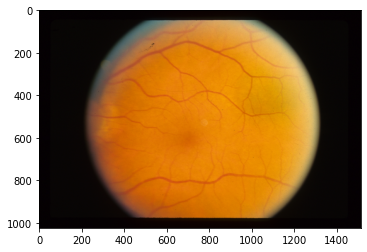

In [32]:
plt.imshow(img)

In [25]:
patient_dict["1478"]

{'re': {'re_year': [3.0, 3.5, 5.0, 7.0],
  're_img': ['60799 06 F2 RE LS.jpg',
   '60799 07 F2 RE LS.jpg',
   '60799 10 F2 RE LS.jpg',
   '60799 14 F2 RE LS.jpg'],
  're_severe_score': [11.0, 11.0, 11.0, 12.0],
  're_late_amd': array([1, 1, 1, 1])},
 'le': {'le_year': [3.0, 3.5, 5.0, 7.0],
  'le_img': ['60799 06 F2 LE LS.jpg',
   '60799 07 F2 LE LS.jpg',
   '60799 10 F2 LE LS.jpg',
   '60799 14 F2 LE LS.jpg'],
  'le_severe_score': [2.0, 2.0, 4.0, 6.0],
  'le_late_amd': array([0, 0, 0, 0])},
 'late_amd_label': 1}